In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [5]:

class KAN8Layer(tf.Module):
    def __init__(self, 
                 inpDim, 
                 outDim, 
                 G = 5, 
                 p= 3, 
                 gridRange = [-1.0, 1.0], 
                 intGrid = 10,
                 intGridRange = [-2.0, 2.0],
                 seed = 100, 
                 name = "KAN"):
        super().__init__(name = name)

        self.inpDim = inpDim
        self.outDim = outDim
        self.G = G
        self.p = p
        self.gridRange = gridRange
        self.seed = seed
        self.name = name
        self.BSplineFunc = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][self.p]
        self.intGrid = intGrid
        self.intGridRange = intGridRange

        #Initialize Variables
        stddev = tf.math.sqrt(2 / (inpDim + outDim))
        self.Phi = tf.Variable(tf.random.normal([self.inpDim, self.outDim, self.G], mean = 0.0, stddev = 0.01, seed = self.seed), 
                               dtype = tf.float32, name = self.name+"_Phi")
        self.W = tf.Variable(tf.random.normal([self.inpDim, self.outDim], mean = 0.0, stddev = stddev, seed = self.seed),
                            dtype = tf.float32, name = self.name+"_W")

        self.InitializeIntGrid()

    def InitializeIntGrid(self):
        N = 10000
        IntGridVals = np.zeros([self.G, self.intGrid], dtype = np.float32)
        SiluIntGridVals = np.zeros([1, self.intGrid], dtype = np.float32)
        GdeltaD = (self.intGridRange[1] - self.intGridRange[0]) / (self.intGrid)
        GdeltaG = (self.gridRange[1] - self.gridRange[0])/(self.G+self.p)
        for j in range(self.intGrid):
            points = tf.random.uniform([N, 1, 1], 
                                       minval = (j * GdeltaD + self.intGridRange[0]), 
                                       maxval = ((j+1)*GdeltaD + self.intGridRange[0]))
            for i in range(self.G):
                Tj = tf.ones([N, 1, 1], tf.float32) * (j * GdeltaG + self.gridRange[0])
                IntGridVals[i][j] = tf.reduce_mean(self.BSplineFunc(points, Tj, GdeltaG))

            SiluIntGridVals[0][j] = tf.reduce_mean(points/(1+tf.exp(-points)))
            
        self.IntGridVals = tf.constant(IntGridVals, tf.float32)
        self.SiluIntGridVals = tf.constant(SiluIntGridVals, tf.float32)

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline0(self, T, Ti, Gdelta):
        temp1 = tf.cast(tf.where(((Ti <= T) & (T < (Ti + Gdelta))), 1.0, 0.0), tf.float32)
        return temp1
        
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline1(self, T, Ti, Gdelta):
        temp0 = 1 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline0(T, Ti, Gdelta) ) + ( diff1 * self.BSpline0(T, Ti+Gdelta, Gdelta) )
        return temp2

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline2(self, T, Ti, Gdelta):
        temp0 = 2 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline1(T, Ti, Gdelta) ) + ( diff1 * self.BSpline1(T, Ti+Gdelta, Gdelta) )
        return temp2
        
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline3(self, T, Ti, Gdelta):
        temp0 = 3 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline2(T, Ti, Gdelta) ) + ( diff1 * self.BSpline2(T, Ti+Gdelta, Gdelta) )
        return temp2

    
    def SplineFromGVals(self, X, AVals, gridRange, p, G, func):
        dist = (gridRange[1] - gridRange[0]) / tf.cast(p + G, tf.float32)
        #func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][p]
        tempX = tf.expand_dims(tf.cast(tf.repeat(tf.expand_dims(X, axis = 1), G, axis = 1), tf.float32), axis = 2)
        siz = tf.gather(tf.shape(X), 0)
        tempXi = tf.transpose(tf.repeat(tf.expand_dims(tf.range(0, G, 1.0)*dist + gridRange[0], axis = 1), siz, axis = 1))
        tempXi = tf.expand_dims(tempXi, axis = 2)
        return tf.matmul(tf.cast(AVals, tf.float32), 
                         tf.transpose(tf.squeeze(func(tempX, tempXi, dist), axis = 2)))

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype = tf.int32),))
    def RegularizationLoss(self, IntPointCount):
        ApproxInt = tf.abs(tf.matmul(self.Phi, self.IntGridVals) + tf.squeeze(self.SiluIntGridVals, axis = 0))
        PCount = tf.cast(IntPointCount, tf.float32)
        PCount = PCount / (1e-9 + tf.repeat(tf.expand_dims(tf.reduce_sum(PCount, axis = 1), axis = 1), self.intGrid, axis = 1))
        PCount = tf.repeat(tf.expand_dims(PCount, axis = 1), self.outDim, axis = 1)
        temp0 = tf.reduce_mean(PCount * ApproxInt, axis = 2) * tf.abs(self.W)
        
        #We rate whichever node needs to be here And whichever needs to be pruned
        inpNeur = tf.where(tf.reduce_max(temp0, axis = 1) > 1e-2, 1, 0)
        outNeur = tf.where(tf.reduce_max(temp0, axis = 0) > 1e-2, 1, 0)
        
        KL = tf.reduce_sum(temp0)
        temp1 = temp0 / (KL + 1e-9)
        temp1 = temp1 * tf.math.log(temp1 + 1e-9)
        KS = -tf. reduce_sum(temp1)
        #KW = tf.reduce_sum(tf.abs(self.W))
        return ((KL + KS), (inpNeur, outNeur))
        
    
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype = tf.float32),))
    def Spline(self, X):
        Gdelta = (self.gridRange[1] - self.gridRange[0])/(self.G+self.p)
        GdeltaD = (self.intGridRange[1] - self.intGridRange[0])/(self.intGrid)
        
        GdeltaD = tf.cast((self.intGridRange[1] - self.intGridRange[0]), tf.float32)/tf.cast(self.intGrid, tf.float32)
        PCount = tf.cast(tf.floor((X - self.intGridRange[0])/GdeltaD), tf.int32)
        lowCount = tf.reduce_sum(tf.where(PCount < 0, 1, 0), axis = 0)
        highCount = tf.reduce_sum(tf.where(PCount >= (self.intGrid), 1, 0), axis = 0)
        PCount = tf.maximum(PCount, 0)
        PCount = tf.minimum(PCount, self.intGrid-1)
        IntPointCount = tf.zeros([self.inpDim, self.intGrid], tf.int32)
        PLocs = tf.expand_dims(tf.transpose(tf.repeat(tf.expand_dims(tf.range(self.inpDim), axis = 1),
                                                      self.inpDimN, axis = 1)), axis = 2)
        PLocs = tf.concat([PLocs, tf.expand_dims(PCount, axis = 2)], axis = 2)
        IntPointCount = tf.tensor_scatter_nd_add(IntPointCount, PLocs, tf.ones([self.inpDimN, self.inpDim], dtype = tf.int32))
        PLocs = tf.expand_dims(tf.range(self.inpDim), axis = 1)
        PLocs = tf.concat([PLocs, tf.zeros([self.inpDim, 1], tf.int32)], axis = 1)
        IntPointCount = tf.tensor_scatter_nd_add(IntPointCount, PLocs, -lowCount)
        PLocs = tf.expand_dims(tf.range(self.inpDim), axis = 1)
        PLocs = tf.concat([PLocs, (self.intGrid-1)*tf.ones([self.inpDim, 1], tf.int32)], axis = 1)
        IntPointCount = tf.tensor_scatter_nd_add(IntPointCount, PLocs, -highCount)
        regloss, Neurs = self.RegularizationLoss(IntPointCount)
        
        X = tf.repeat(tf.expand_dims(X, axis = 2), self.G, axis = 2)
        Xi = tf.ones(tf.shape(X), tf.float32) * (tf.range(0, self.G, 1.0) * Gdelta + self.gridRange[0])
        Y = self.BSplineFunc(X, Xi, Gdelta)
        
        Y = tf.transpose(Y, [2, 0, 1])
        PhiTemp = tf.transpose(self.Phi, [2, 0, 1])
        Out = tf.matmul(tf.gather(Y, 0), tf.gather(PhiTemp, 0)*self.W)
        for i in tf.range(1, self.G):
            Out = Out + tf.matmul(tf.gather(Y, i), tf.gather(PhiTemp, i)*self.W)

        return (Out, regloss, Neurs)

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype = tf.float32),))
    def __call__(self, X):
        self.inpDimN = tf.gather(tf.shape(X), 0)
        silu = X / (1+tf.exp(-X))
        spline, regloss, Neurs = self.Spline(X)
        return ((tf.matmul(silu, self.W) + spline), regloss, Neurs)

    
    def UpdateGrid(self, Gnew, Pnew, gridRange, X_Y = (0, 0), stddev = 0.0):

        #Define the array (can also set this block to constant as the Arr value doesnt really change)
        X = tf.linspace(-0.25, 1.25, 100000, axis = 0)
        Arr = np.zeros([4, 5])
        func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3]
        for p in range(4):
            for a in range(5):
                Y = func[p](tf.expand_dims(tf.expand_dims(X, axis = 1), axis = 2), 
                            tf.zeros([100000, 1, 1], tf.float32), 
                            1/(p+1)) * func[p](tf.expand_dims(tf.expand_dims(X, axis = 1), axis = 2), 
                                               tf.ones([100000, 1, 1], tf.float32) * a/(p+1), 
                                               1/(p+1))
                Y = tf.squeeze(tf.squeeze(Y, axis = 2), axis = 1)
                Arr[p][a] = tfp.math.trapz(Y, X).numpy()
        
        #Block to make the inverse matrix for multiplication later on
        MulArr = np.zeros([Gnew, Gnew])
        temp = (Gnew+Pnew)/((Pnew+1) * (gridRange[1] - gridRange[0]))
        for i in range(Gnew):
            for j in range(Gnew):
                MulArr[i][j] = Arr[Pnew][np.minimum((Pnew+1), np.abs(i-j))] / temp
        invMulArr = tf.cast(tf.linalg.inv(MulArr), tf.float32)

        #Calculate the Spline for Phi G Values
        N = 2000
        X = tf.linspace(gridRange[0], gridRange[1], N, axis = 0)
        func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][self.p]
        Y = self.SplineFromGVals(X, self.Phi, self.gridRange, self.p, self.G, func)
        Y = tf.repeat(tf.expand_dims(Y, axis = 2), Gnew, axis = 2)
        
        #Calculate All the BSplines to Multiply
        func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][Pnew]
        Gdelta = (gridRange[1] - gridRange[0]) / (Gnew + Pnew)
        B = []
        for i in range(Gnew):
            B.append(tf.squeeze(tf.squeeze(func(tf.expand_dims(tf.expand_dims(X, axis = 1), axis = 2), 
                                                tf.ones([N, 1, 1]) * (gridRange[0] + tf.cast(i*(Gdelta), tf.float32)), 
                                                Gdelta), 
                                           axis = 2), axis = 1))
        B = tf.constant(np.array(B), tf.float32)      

        #Integrate the Y*B and calculate the new Phi from matmul
        IntSpace = tfp.math.trapz((Y*B), tf.ones(tf.shape(Y), tf.float32) * X, axis = 3)
        PhiN = tf.matmul(IntSpace, tf.transpose(invMulArr)) + tf.random.normal([self.inpDim, self.outDim, Gnew], mean = 0.0,
                                                                              stddev = stddev)
        return {"Phi": PhiN, "W": self.W}

    def assignValues(self, Vars):
        if "Phi" in Vars:
            self.Phi.assign(Vars["Phi"])
        if "W" in Vars:
            self.W.assign(Vars["W"])

In [6]:
inpDim = 1
outDim = 1
kan0 = KAN8Layer(inpDim, outDim, 15, 1, [-1, 1], name = "KAN8")

In [7]:
P = 1
G = 30
gridRange = [-1.5, 1.5]
Vars = kan0.UpdateGrid(G, P, tf.constant(gridRange), stddev = 0.01)

In [8]:
kan1 = KAN8Layer(inpDim, 
                 outDim, 
                 G, 
                 P, 
                 gridRange,
                 name = "layer0", 
                 seed = 100)

kan1.assignValues(Vars)

In [9]:
N = 10000
X = tf.random.uniform([N, inpDim], minval=-2, maxval = 2)
X = tf.sort(X, axis = 0)
Y0, re0, Neur0 = kan0(X)
Y1, re1, Neur1 = kan1(X)


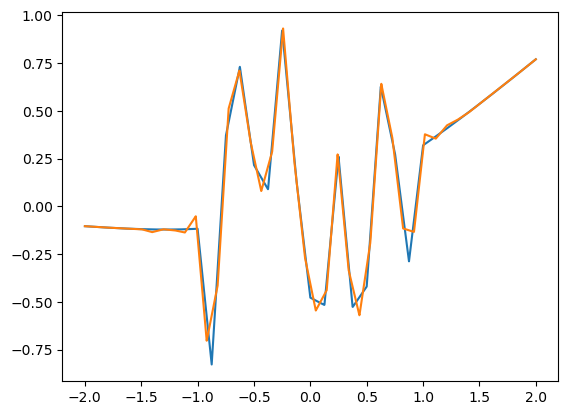

In [77]:
plt.plot(X, Y0)
plt.plot(X, Y1)